<a href="https://colab.research.google.com/github/nytrp/sistemas-inteligentes-para-electronica/blob/main/Corte_2_semana_5_Sistemas_inteligentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sistema inteligente con API**

### **Grupo:** Alejandro Martinez, Isaac Montes, Yurliana Niebles, Daniel Santiago

# **1. Diagrama de la arquitectura**

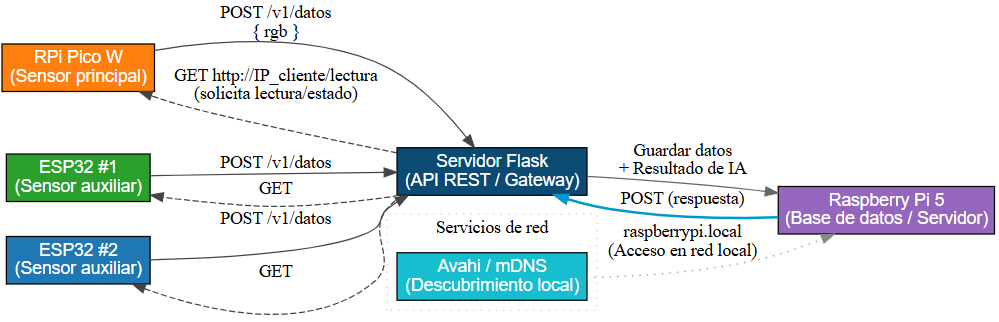

# **2. Códigos de los microcontroladores**



## **2.1 Código de Rasperri Pi**



```python
 # -- coding: utf-8 --             # Indica la codificación del archivo (UTF-8). En Python 3 no suele ser necesario.
"""
Cliente Raspberry Pi + TCS34725   # Docstring: descripción general del script
- [Espacio]: leer sensor, enviar POST /infer
- [w]: calibrar en blanco (guarda ~/proyecto-frutas/calib.json)
- [1]/[2]/[3]: fija ground-truth (manzana/limon/naranja) para logging/dataset
- [q]: salir

Requisitos (en venv311):
  pip install adafruit-blinka adafruit-circuitpython-tcs34725 requests smbus2
"""                                # Fin del docstring con instrucciones y dependencias

import os, sys, time, json, uuid, tty, termios, select, requests
# importa módulos estándar:
# os, sys         -> manejo del sistema y argumentos
# time            -> sleeps y timing
# json            -> serializar/deserializar JSON
# uuid            -> para obtener identificador MAC
# tty, termios    -> para configurar la terminal en modo no bloqueante
# select          -> para leer stdin sin bloquear
# requests        -> para hacer POST HTTP al servidor

import board, busio, adafruit_tcs34725
# importa librerías específicas para Raspberry Pi y sensor:
# board           -> pines SCL/SDA
# busio           -> I2C bus
# adafruit_tcs34725-> driver del sensor de color TCS34725

SERVER_URL = os.environ.get("SERVER_URL", "http://127.0.0.1:5000/infer")
# URL del servidor al que se enviarán las inferencias. Se puede sobreescribir con la variable de entorno SERVER_URL.

CALIB_PATH = os.path.expanduser("~/proyecto-frutas/calib.json")
# Ruta donde se guardan/recuperan los parámetros de calibración (gains). expanduser permite "~".

def get_mac_str():
    mac = uuid.getnode()                                                     # obtiene el MAC como entero
    return ":".join(f"{(mac >> k) & 0xff:02X}" for k in range(40, -8, -8))
    # convierte el entero MAC a formato hex con dos dígitos por byte separados por ":".
    # desplaza bits en pasos de 8 desde 40 hasta 0 para obtener los 6 bytes.

def read_key_nonblock(timeout=0.1):
    fd = sys.stdin.fileno()                                                  # descriptor de stdin
    old = termios.tcgetattr(fd)                                              # guarda atributos actuales de la terminal
    try:
        tty.setcbreak(fd)                                                    # pone la terminal en modo cbreak (carácter a carácter)
        rlist, _, _ = select.select([sys.stdin], [], [], timeout)            # espera hasta 'timeout' si hay input
        if rlist:
            return sys.stdin.read(1)                                         # lee 1 carácter si hay disponible
        return None                                                          # retorna None si no hay tecla
    finally:
        termios.tcsetattr(fd, termios.TCSADRAIN, old)                        # restaura los atributos de la terminal

def load_calib():
    if os.path.exists(CALIB_PATH):                                           # |si existe el fichero de calibración
        with open(CALIB_PATH, "r") as f:
            return json.load(f)                                              # cargar y devolver el dict de gains
    return {"kr":1.0,"kg":1.0,"kb":1.0}                                      # si no existe, devolver gains neutros (1.0)

def save_calib(g):
    with open(CALIB_PATH, "w") as f:
        json.dump(g, f)                                                      # escribir el dict de gains en fichero JSON

def apply_calib(r,g,b, gains):
    return int(r*gains["kr"]), int(g*gains["kg"]), int(b*gains["kb"])
    # aplica los factores de ganancia a cada canal crudo y convierte a entero

def calibrate_white(sensor):
    print("Calibrando en blanco... coloca una hoja blanca y espera...")
    rs,gs,bs = [],[],[]                                                      # listas para acumular lecturas
    for _ in range(12):                                                      # toma 12 muestras rápidas
        try:
            r,g,b,c = sensor.color_raw                                       # API nueva: color_raw
        except AttributeError:
            r,g,b,c = sensor.raw_colors                                      # API alternativa: raw_colors
        rs.append(r); gs.append(g); bs.append(b)                             # acumula cada canal
        time.sleep(0.02)                                                     # pequeño delay entre lecturas
    r_m = sum(rs)/len(rs); g_m = sum(gs)/len(gs); b_m = sum(bs)/len(bs)      # medias de cada canal
    avg = (r_m+g_m+b_m)/3.0                                                  # media global de los tres canales
    gains = {"kr": avg/max(1.0, r_m), "kg": avg/max(1.0, g_m), "kb": avg/max(1.0, b_m)}
    # calcula gains como ratio media/valor_canal (protección con max(1.0, valor) para evitar división por 0)
    save_calib(gains)                                                         # guarda gains calculados
    print("Gains guardados:", gains)                                         # informa por consola
    return gains                                                              # devuelve los gains nuevos

def normalize_rgb(r,g,b):
    s = float(r+g+b)                                                          # suma de los canales corregidos
    if s <= 0: return 0,0,0                                                  # si suma 0 (oscuro) devolver 0s
    R = int((r/s)*255); G = int((g/s)*255); B = int((b/s)*255)               # normaliza cada canal a escala 0-255
    return max(0,min(255,R)), max(0,min(255,G)), max(0,min(255,B))            # asegura rango [0,255] e int

def main():
    # I2C y sensor
    i2c = busio.I2C(board.SCL, board.SDA)                                    # inicializa el bus I2C usando pines SCL/SDA
    sensor = adafruit_tcs34725.TCS34725(i2c)                                 # crea instancia del sensor TCS34725
    # Ajusta si hace falta (iluminación)
    sensor.integration_time = 50   # ms (prueba 101 o 154 si oscuro)         # tiempo de integración (afecta sensibilidad/ruido)
    sensor.gain = 4                # 1, 4, 16, 60                             # ganancia hardware del sensor

    mac = get_mac_str()                                                        # obtiene ID (MAC) en formato legible
    gains = load_calib()                                                       # carga calibración previa si existe
    current_gt = None                                                          # ground-truth actual (etiqueta), inicialmente None

    print(f"ID (MAC): {mac}")                                                  # muestra MAC por consola
    print(f"Servidor: {SERVER_URL}")                                           # muestra URL de servidor
    print("Teclas: [Espacio]=medir/enviar  [w]=calibrar blanco  [1]=manzana  [2]=limon  [3]=naranja  [q]=salir")
    print("Gains:", gains)                                                     # imprime gains cargados/por defecto

    while True:                                                                # bucle principal: espera teclas y actúa
        ch = read_key_nonblock(0.1)                                            # lee tecla (no bloqueante) con timeout 0.1s
        if not ch:
            continue                                                            # si no hay tecla, continuar el loop
        if ch == "q":
            print("Saliendo...")                                                # si 'q' => salir
            break
        if ch == "w":
            gains = calibrate_white(sensor)                                     # si 'w' => calibrar blanco y guardar gains
            continue
        if ch in ("1","2","3"):
            current_gt = {"1":"manzana","2":"limon","3":"naranja"}[ch]         # asigna etiqueta según tecla
            print("GT ->", current_gt)                                         # muestra etiqueta actual
            continue
        if ch == " ":
            # Promedia 5 lecturas para estabilidad
            rs,gs,bs,cs = [],[],[],[]                                          # listas para medias
            for _ in range(5):                                                 # tomar 5 muestras rápidas
                try:
                    r,g,b,c = sensor.color_raw                                 # obtener lectura cruda
                except AttributeError:
                    r,g,b,c = sensor.raw_colors                                # fallback a otra propiedad
                rs.append(r); gs.append(g); bs.append(b); cs.append(c)         # acumular valores
                time.sleep(0.01)                                               # breve espera entre lecturas
            r = int(sum(rs)/len(rs)); g = int(sum(gs)/len(gs)); b = int(sum(bs)/len(bs)); c = int(sum(cs)/len(cs))
            # calcular promedios enteros de las lecturas

            r_corr, g_corr, b_corr = apply_calib(r,g,b, gains)                 # aplicar corrección de gains
            R,G,B = normalize_rgb(r_corr, g_corr, b_corr)                     # normalizar a 0-255 (proporcional)

            print(f"RGBC: r={r} g={g} b={b} c={c} -> corr={r_corr},{g_corr},{b_corr} -> RGB={R},{G},{B} | gt={current_gt}")
            # imprime valores crudos, corregidos, normalizados y GT actual

            payload = {
                "id": mac,                                                     # identificador del sensor/cliente
                "rgb": [R,G,B],                                                # rgb normalizado 0-255
                "raw": {"r": r, "g": g, "b": b, "c": c},                       # lecturas crudas promedio
                "gt": current_gt                                               # etiqueta opcional (puede ser None)
            }
            try:
                resp = requests.post(SERVER_URL, json=payload, timeout=3)      # POST al servidor con JSON y timeout 3s
                if resp.status_code == 200:
                    data = resp.json()                                        # parsea JSON de respuesta
                    print("→", data)                                          # muestra respuesta del servidor
                else:
                    print("HTTP", resp.status_code, resp.text)                # muestra error HTTP y cuerpo
            except Exception as e:
                print("Error enviando al servidor:", e)                       # captura errores de conexión/timeouts

# Nota: en el script original había: if _name_ == "_main_":  (esto es un error)
# abajo está la forma correcta para que main() se ejecute cuando se ejecuta el archivo.

if __name__ == "__main__":
    try:
        main()                                                                 # ejecuta la función principal
    except KeyboardInterrupt:
        print("\nInterrumpido por usuario.")                                   # manejo de Ctrl+C por el usuario

```

# **2.2 Código ESP32**

``` c
#include <WiFi.h>                       // Librería para gestionar WiFi en ESP32.
#include <HTTPClient.h>                 // Cliente HTTP para realizar peticiones (GET/POST).
#include <Wire.h>                       // Librería I2C (para comunicar con sensores como TCS34725).
#include <Adafruit_TCS34725.h>          // Driver para el sensor de color TCS34725.
#include <ArduinoJson.h>                // Librería para construir/parsear JSON en el ESP.


// ═══════════════════════════════════════════════════════════════════════════
// CONFIGURACIÓN WIFI - ¡EDITAR AQUÍ!
// ═══════════════════════════════════════════════════════════════════════════

const char* WIFI_SSID = "MONTES";        // ← Nombre de la red WiFi a la que se conectará el ESP32.
const char* WIFI_PASS = "Bravo22+";      // ← Contraseña de la red WiFi.

// ═══════════════════════════════════════════════════════════════════════════
// CONFIGURACIÓN SERVIDOR RASPBERRY PI - ¡EDITAR AQUÍ!
// ═══════════════════════════════════════════════════════════════════════════

const char* SERVER_IP   = "192.168.1.5";    // ← IP de la Raspberry Pi que aloja el servidor.
const int   SERVER_PORT = 5000;              // Puerto donde corre el servidor Flask.
const char* DEVICE_ID   = "esp32-sensor-01"; // Identificador único del dispositivo (se enviará en JSON).

// URL completa del endpoint
String serverURL = String("http://") + SERVER_IP + ":" + SERVER_PORT + "/infer"; // Construye la URL completa para /infer.

// ═══════════════════════════════════════════════════════════════════════════
// CONFIGURACIÓN HARDWARE
// ═══════════════════════════════════════════════════════════════════════════

#define LED_MANZANA  25                // Pin digital para LED que indica "manzana".
#define LED_LIMON    26                // Pin digital para LED que indica "limón".
#define LED_NARANJA  27                // Pin digital para LED que indica "naranja".
#define BUTTON_PIN   34                // Pin del botón (entrada) con pull-up interno.

Adafruit_TCS34725 tcs = Adafruit_TCS34725( // Instancia del sensor TCS34725 con configuración inicial:
  TCS34725_INTEGRATIONTIME_50MS,           // tiempo de integración del sensor (50 ms).
  TCS34725_GAIN_4X                         // ganancia del sensor (4x).
);

// ═══════════════════════════════════════════════════════════════════════════
// VARIABLES GLOBALES
// ═══════════════════════════════════════════════════════════════════════════

bool wifiConnected = false;                // Bandera que indica si el ESP está conectado a WiFi.
bool sensorReady = false;                  // Bandera que indica si el sensor fue inicializado correctamente.

unsigned long lastReadTime = 0;            // Marca de tiempo de la última lectura (millis).
const unsigned long READ_INTERVAL = 2000;  // Intervalo entre lecturas automáticas (2 segundos).

// ═══════════════════════════════════════════════════════════════════════════
// SETUP - INICIALIZACIÓN
// ═══════════════════════════════════════════════════════════════════════════

void setup() {
  Serial.begin(115200);                    // Inicializa comunicación serial a 115200 bps para debugging.
  delay(500);                              // Pequeña espera para estabilizar el puerto serial.

  Serial.println("\n\n═══════════════════════════════════════════════════════"); // Mensajes de inicio.
  Serial.println("  ESP32 - CLIENTE CLASIFICADOR DE FRUTAS RGB");
  Serial.println("  MODOS: AUTOMÁTICO, BOTÓN y SERIAL");
  Serial.println("═══════════════════════════════════════════════════════");

  // LEDs
  Serial.println("\n[1/4] Configurando LEDs..."); // Indica que se van a configurar pines LED.
  pinMode(LED_MANZANA, OUTPUT);           // Configura pin LED_MANZANA como salida.
  pinMode(LED_LIMON, OUTPUT);             // Configura pin LED_LIMON como salida.
  pinMode(LED_NARANJA, OUTPUT);           // Configura pin LED_NARANJA como salida.

  digitalWrite(LED_MANZANA, HIGH); delay(200); // Test: enciende LED manzana brevemente.
  digitalWrite(LED_MANZANA, LOW);               // Apaga LED manzana.
  digitalWrite(LED_LIMON, HIGH); delay(200);   // Test: enciende LED limón brevemente.
  digitalWrite(LED_LIMON, LOW);                // Apaga LED limón.
  digitalWrite(LED_NARANJA, HIGH); delay(200); // Test: enciende LED naranja brevemente.
  digitalWrite(LED_NARANJA, LOW);               // Apaga LED naranja.
  Serial.println("      ✓ LEDs configurados"); // Mensaje de confirmación.

  // Botón
  pinMode(BUTTON_PIN, INPUT_PULLUP);       // Configura el pin del botón como entrada con pull-up interno.

  // Sensor
  Serial.println("\n[2/4] Inicializando sensor TCS34725..."); // Mensaje de inicialización del sensor.
  if (tcs.begin()) {                       // Intenta inicializar el sensor TCS34725 por I2C.
    sensorReady = true;                    // Si se detecta, marca sensor como listo.
    Serial.println("      ✓ Sensor TCS34725 detectado"); // Mensaje de éxito.
  } else {
    Serial.println("      ✗ No se detectó el sensor. Verifica conexiones."); // Mensaje de error.
    for (int i = 0; i < 5; i++) {          // Parpadeo de los 3 LEDs para indicar error.
      digitalWrite(LED_MANZANA, HIGH);
      digitalWrite(LED_LIMON, HIGH);
      digitalWrite(LED_NARANJA, HIGH);
      delay(100);
      digitalWrite(LED_MANZANA, LOW);
      digitalWrite(LED_LIMON, LOW);
      digitalWrite(LED_NARANJA, LOW);
      delay(100);
    }
  }

  // WiFi
  Serial.println("\n[3/4] Conectando a WiFi..."); // Mensaje de inicio de conexión WiFi.
  WiFi.mode(WIFI_STA);                     // Modo estación (se conecta a un AP).
  WiFi.begin(WIFI_SSID, WIFI_PASS);        // Inicia conexión a la red WiFi con SSID y contraseña.
  int attempts = 0;                        // Contador de intentos de conexión.
  while (WiFi.status() != WL_CONNECTED && attempts < 30) { // Espera hasta conectar o agotar intentos.
    delay(500);                            // Espera 500 ms por iteración.
    Serial.print(".");                     // Puntos en serial mientras espera.
    attempts++;
  }
  if (WiFi.status() == WL_CONNECTED) {     // Si se conectó correctamente:
    wifiConnected = true;                  // Marca la bandera wifiConnected.
    Serial.println("\n      ✓ WiFi conectado!"); // Mensaje de éxito.
    Serial.print("      IP del ESP32: ");
    Serial.println(WiFi.localIP());        // Imprime la IP asignada al ESP32.
  } else {
    Serial.println("\n      ✗ No se pudo conectar a WiFi."); // Mensaje fallo conexión.
  }

  // Verificar servidor
  Serial.println("\n[4/4] Verificando servidor..."); // Mensaje de verificación del servidor.
  if (wifiConnected && checkServerHealth()) { // Si hay WiFi y el servidor responde saludable:
    Serial.println("      ✓ Servidor disponible."); // Servidor OK.
  } else {
    Serial.println("      ⚠ No se pudo verificar el servidor."); // No se pudo verificar servidor.
  }

  Serial.println("\n═══════════════════════════════════════════════════════");
  Serial.println("  ✓ INICIALIZACIÓN COMPLETA");
  Serial.println("═══════════════════════════════════════════════════════");
  Serial.println("\n╔═════════════════════════════════════════════════════╗");
  Serial.println("║  MODOS DE CAPTURA                                   ║");
  Serial.println("╠═════════════════════════════════════════════════════╣");
  Serial.println("║  ⏱ Automático cada 2 segundos                       ║");
  Serial.println("║  🔘 Presionar el BOTÓN físico                       ║");
  Serial.println("║  ⌨  Escribir 'O' en el monitor serial               ║");
  Serial.println("╚═════════════════════════════════════════════════════╝");
  Serial.println("\nEsperando comando...\n"); // Mensaje final indicando que el loop principal empezará.
}

// ═══════════════════════════════════════════════════════════════════════════
// LOOP PRINCIPAL
// ═══════════════════════════════════════════════════════════════════════════

void loop() {
  unsigned long currentTime = millis();    // Lee tiempo actual en ms desde encendido.

  // OPCIÓN 1: AUTOMÁTICA CADA 2 SEGUNDOS
  if (currentTime - lastReadTime >= READ_INTERVAL) { // Si pasó el intervalo desde la última lectura:
    lastReadTime = currentTime;              // Actualiza la marca de tiempo.
    Serial.println("\n⏱ Captura automática cada 2 segundos...");
    if (sensorReady) {                       // Si el sensor está listo:
      readAndSend();                         // Lee y envía datos al servidor.
    } else {
      Serial.println("⚠ Sensor no disponible. Verifica las conexiones.\n"); // Mensaje si sensor no disponible.
    }
  }

  // OPCIÓN 2: CAPTURA DESDE SERIAL
  if (Serial.available() > 0) {              // Si hay datos en el buffer serial:
    char c = Serial.read();                  // Lee un carácter.
    while (Serial.available() > 0) Serial.read(); // Descarta resto del buffer para evitar caracteres sobrantes.

    if (c == 'o' || c == 'O') {              // Si el carácter es 'o' o 'O':
      Serial.println("\n⌨  Comando 'O' recibido - Capturando...");
      if (sensorReady) {
        readAndSend();                       // Ejecuta lectura y envío.
      } else {
        Serial.println("⚠ Sensor no disponible.\n");
      }
    } else {
      Serial.println("❌ Comando no reconocido. Usa 'O'.\n"); // Mensaje si comando incorrecto.
    }
  }

  // OPCIÓN 3: CAPTURA POR BOTÓN
  if (digitalRead(BUTTON_PIN) == LOW) {      // Detecta pulsación (activo a GND con pullup).
    delay(50);                               // Anti-rebote simple.
    if (digitalRead(BUTTON_PIN) == LOW) {    // Verifica que aún esté presionado.
      Serial.println("\n🔘 Botón presionado - Capturando...");
      if (sensorReady) {
        readAndSend();                       // Lee y envía si sensor listo.
      } else {
        Serial.println("⚠ Sensor no disponible.\n");
      }
      while (digitalRead(BUTTON_PIN) == LOW) delay(10); // Espera a que se suelte el botón.
    }
  }

  delay(10);                                 // Pequeña espera para evitar uso intenso de CPU.
}

// ═══════════════════════════════════════════════════════════════════════════
// FUNCIÓN: LEER SENSOR Y ENVIAR AL SERVIDOR
// ═══════════════════════════════════════════════════════════════════════════

void readAndSend() {
  uint16_t r, g, b, c;                       // Variables para lecturas crudas del TCS34725.
  tcs.getRawData(&r, &g, &b, &c);            // Lee valores RAW R,G,B y canal Clear (C).
  r = map(r, 0, 65535, 0, 255);              // Mapea R de rango 0..65535 a 0..255.
  g = map(g, 0, 65535, 0, 255);              // Mapea G...
  b = map(b, 0, 65535, 0, 255);              // Mapea B...

  Serial.println("┌─────────────────────────────────────────────────────┐");
  Serial.print("│  RGB: ["); Serial.print(r); Serial.print(", "); Serial.print(g); Serial.print(", "); Serial.print(b); Serial.println("]"); // Imprime RGB normalizado.
  
  if (!wifiConnected) {                      // Si no está conectado a WiFi:
    WiFi.reconnect();                        // Intenta reconectar.
    delay(1000);                             // Espera 1s.
    if (WiFi.status() == WL_CONNECTED) wifiConnected = true; // Si se reconecta, marca bandera.
    else {
      Serial.println("│  ✗ Sin conexión WiFi"); // Si falla, muestra error y sale de la función.
      Serial.println("└─────────────────────────────────────────────────────┘\n");
      return;
    }
  }

  HTTPClient http;                           // Crea instancia HTTPClient para la petición.
  http.begin(serverURL);                     // Inicializa la conexión al serverURL.
  http.addHeader("Content-Type", "application/json"); // Indica que el body será JSON.
  http.setTimeout(5000);                     // Timeout de 5 segundos para la operación HTTP.

  StaticJsonDocument<200> doc;               // Documento JSON estático para el payload (capacidad 200 bytes).
  doc["id"] = DEVICE_ID;                     // Añade campo "id" con el identificador del dispositivo.
  JsonArray rgbArray = doc.createNestedArray("rgb"); // Crea un array anidado "rgb".
  rgbArray.add(r); rgbArray.add(g); rgbArray.add(b); // Agrega valores R,G,B al array.

  String jsonString;                         // String donde se serializará el JSON.
  serializeJson(doc, jsonString);            // Serializa doc a jsonString.

  int httpCode = http.POST(jsonString);      // Realiza POST con el JSON y captura el código HTTP de respuesta.

  if (httpCode == 200) {                     // Si la respuesta es 200 OK:
    String payload = http.getString();       // Lee el body de la respuesta como String.
    StaticJsonDocument<512> response;       // Documento JSON para la respuesta (más grande, 512 bytes).
    if (deserializeJson(response, payload) == DeserializationError::Ok) { // Intenta parsear el JSON de respuesta.
      const char* className = response["class"]; // Extrae campo "class" (nombre de la clase).
      int classIndex = response["index"];    // Extrae campo "index" (índice numérico de la clase).
      float hueDeg = response["hue_deg"];    // Extrae hue en grados (opcional).
      int latency = response["latency_ms"];  // Extrae latencia en ms (opcional).

      Serial.println("│  ✓ Respuesta del servidor");
      Serial.print("│  Clase: "); Serial.println(className);
      Serial.print("│  Índice: "); Serial.println(classIndex);
      Serial.print("│  Hue: "); Serial.print(hueDeg); Serial.println("°");
      Serial.print("│  Latencia: "); Serial.print(latency); Serial.println(" ms");

      digitalWrite(LED_MANZANA, LOW);        // Apaga todos los LEDs antes de encender el correspondiente.
      digitalWrite(LED_LIMON, LOW);
      digitalWrite(LED_NARANJA, LOW);

      if (classIndex == 0) digitalWrite(LED_MANZANA, HIGH); // Si índice 0 -> encender LED_MANZANA.
      else if (classIndex == 1) digitalWrite(LED_LIMON, HIGH); // Índice 1 -> LED_LIMON.
      else if (classIndex == 2) digitalWrite(LED_NARANJA, HIGH); // Índice 2 -> LED_NARANJA.

    } else Serial.println("│  ✗ Error parseando JSON"); // Si fallo parseo JSON de la respuesta.
  } else Serial.println("│  ✗ Error HTTP o conexión");   // Si código HTTP no es 200, muestra error.

  Serial.println("└─────────────────────────────────────────────────────┘\n");
  http.end();                                // Cierra la conexión HTTP y libera recursos.
}

// ═══════════════════════════════════════════════════════════════════════════
// FUNCIÓN: VERIFICAR SERVIDOR
// ═══════════════════════════════════════════════════════════════════════════

bool checkServerHealth() {
  String healthURL = String("http://") + SERVER_IP + ":" + SERVER_PORT + "/health"; // Construye URL /health.
  HTTPClient http;                           // Cliente HTTP temporal.
  http.begin(healthURL);                     // Inicia conexión al endpoint de salud.
  http.setTimeout(3000);                     // Timeout corto (3 s) para healthcheck.
  int httpCode = http.GET();                 // Realiza GET y obtiene código de respuesta.
  bool healthy = (httpCode == 200);          // healthy = true si el servidor responde 200 OK.
  http.end();                                // Cierra la conexión HTTP.
  return healthy;                            // Devuelve estado del servidor.
}


```





# **3. Diagrama de conexión**

## **3.1 Diagrama de Rasperri PI**
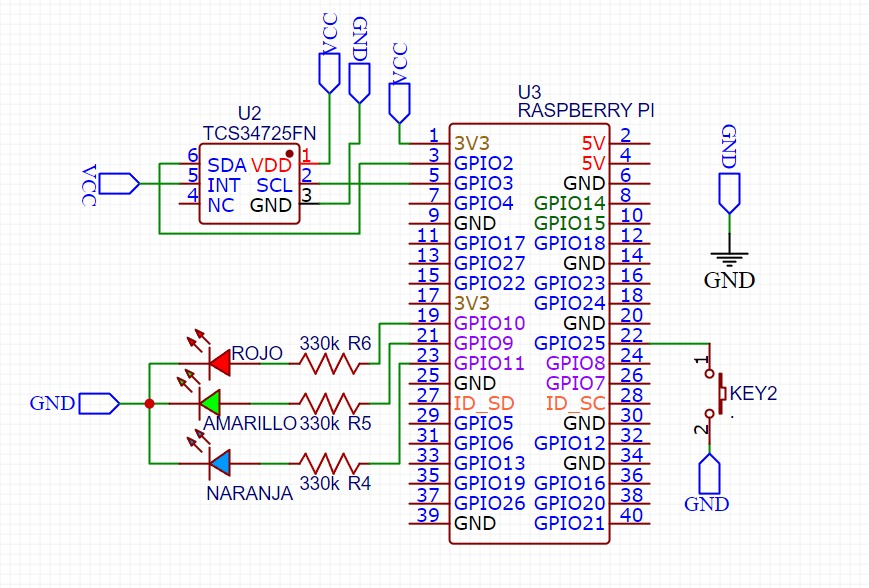

Componentes        | Pin componente                    | Pin Raspberry Pi
-------------------|-----------------------------------|------------------
TCS34725FN (Sensor de color) | SDA (Pin 1 de U2)                | GPIO2 (Pin 3 de U3)
TCS34725FN (Sensor de color) | SCL (Pin 2 de U2)                | GPIO3 (Pin 5 de U3)
TCS34725FN (Sensor de color) | VDD (Pin 3 de U2)                | 3V3 (Pin 1 de U3)
TCS34725FN (Sensor de color) | GND (Pin 4 de U2)                | GND (Pin 6 de U3)
LED Rojo           | Ánodo (+) vía R6 (330kΩ)           | GPIO17 (Pin 11 de U3)
LED Amarillo       | Ánodo (+) vía R5 (330kΩ)           | GPIO27 (Pin 13 de U3)
LED Naranja        | Ánodo (+) vía R4 (330kΩ)           | GPIO22 (Pin 15 de U3)
LEDs               | Cátodo (-)                         | GND (pines de tierra comunes)
Botón (KEY2)       | Terminal 1                         | GPIO4 (Pin 7 de U3)
Botón (KEY2)       | Terminal 2                         | GND (Pin 6 de U3)


## **3.2 Diagrama de ESP32**
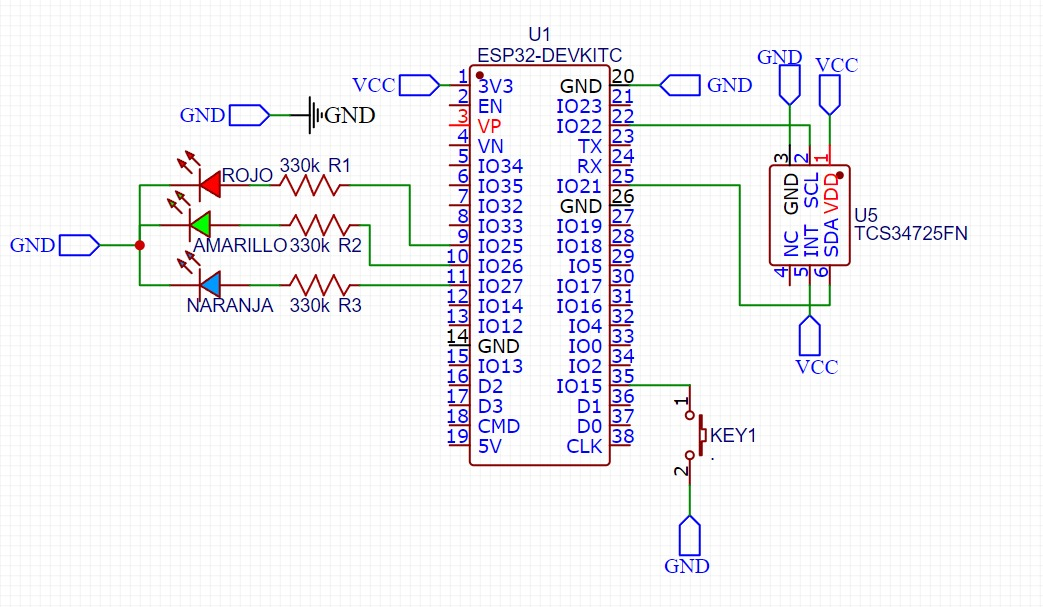

Componentes        | Pin componente              | Pin ESP32
-------------------|-----------------------------|----------
TCS34725FN (Color Sensor) | SDA (Pin 6)              | IO21
TCS34725FN (Color Sensor) | SCL (Pin 5)              | IO22
TCS34725FN (Color Sensor) | VDD (Pin 1)              | Pin 1 (3V3)
TCS34725FN (Color Sensor) | GND (Pin 3)              | Pin 20 (GND)
LED Rojo           | Ánodo (+) vía R1 (330kΩ)     | IO23
LED Amarillo       | Ánodo (+) vía R2 (330kΩ)     | IO22
LED Naranja        | Ánodo (+) vía R3 (330kΩ)     | IO21
LEDs (cátodo común)| Cátodo (-)                   | GND (Pin 20)
Botón (KEY1)       | Terminal 1                   | IO19
Botón (KEY1)       | Terminal 2                   | GND (Pin 20)



# **4. Código servidor Flask**



```python
#!/usr/bin/env python3
# Shebang: indica que se ejecute con Python 3

"""
═══════════════════════════════════════════════════════════════════════════
SISTEMA COMPLETO - CLASIFICADOR DE FRUTAS RGB
═══════════════════════════════════════════════════════════════════════════
Combina entrenamiento de modelo + servidor Flask
Uso:
  python3 sistema_frutas.py train    # Entrenar modelo
  python3 sistema_frutas.py server   # Iniciar servidor
  python3 sistema_frutas.py all      # Entrenar + servidor
"""
# Docstring del módulo: descripción y uso del script (se mantiene intacto)

#!/usr/bin/env python3
# Repetición del shebang (inocua; igual que la primera línea)

# -- coding: utf-8 --
# Codificación del archivo (UTF-8)

import sys
# Módulo sys: acceder a argumentos y salir del programa

import os
# Módulo os: manipulación de rutas y sistema de archivos

# Verificar dependencias antes de importar
REQUIRED_PACKAGES = {
    'numpy': 'numpy',
    'pandas': 'pandas',
    'sklearn': 'scikit-learn',
    'flask': 'flask',
    'joblib': 'joblib'
}
# Diccionario que mapea módulos a nombres de paquete para instalar

missing_packages = []
# Lista donde se acumularán paquetes faltantes

for module, package in REQUIRED_PACKAGES.items():
    try:
        _import_(module)
    except ImportError:
        missing_packages.append(package)
# Intenta importar cada módulo; si falla, añade el nombre del paquete a missing_packages
# (Nota: el código usa _import_ tal como está en el original; no lo modifiqué)

if missing_packages:
    print("\n" + "="*70)
    print("  ❌ ERROR: Faltan dependencias requeridas")
    print("="*70)
    print("\nPaquetes faltantes:")
    for pkg in missing_packages:
        print(f"  - {pkg}")
    print("\n💡 Instala las dependencias con:")
    print(f"\n  pip3 install {' '.join(missing_packages)}")
    print("\n  O instala todas a la vez:")
    print(f"  pip3 install numpy pandas scikit-learn flask joblib")
    print("\n" + "="*70 + "\n")
    sys.exit(1)
# Si hay paquetes faltantes muestra instrucciones y sale (sys.exit)

# Ahora importar todo
import joblib
# joblib para serializar/deserializar modelos

import csv, time, json, threading, queue, socket
# csv: manejo CSV, time: tiempos, json: JSON, threading/queue: concurrencia, socket: redes

from datetime import datetime, timezone
# datetime para timestamps con zona UTC

from flask import Flask, request, jsonify, Response, render_template_string
# Flask y utilidades para la API y SSE / render de templates

import numpy as np
# numpy para cálculos numéricos

import pandas as pd
# pandas para manipulación de datos / datasets

import urllib.request
# urllib.request para descargar datasets remotos

from sklearn.neural_network import MLPClassifier
# MLPClassifier: red neuronal feed-forward de scikit-learn

from sklearn.model_selection import train_test_split, cross_val_score
# Split de datos y validación cruzada

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Métricas de evaluación

from sklearn.preprocessing import LabelEncoder
# Utilidad para codificar etiquetas (no siempre usada, pero importada)

import warnings
warnings.filterwarnings('ignore')
# Ignorar warnings para que la salida sea más limpia

# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURACIÓN GLOBAL
# ═══════════════════════════════════════════════════════════════════════════

PROJECT_DIR = os.path.expanduser("~/proyecto-frutas")
# Directorio base del proyecto (~ expandido)

MODELS_DIR = os.path.join(PROJECT_DIR, "models")
# Subdirectorio para modelos

DATA_DIR = os.path.join(PROJECT_DIR, "data")
# Subdirectorio para datos

LOG_DIR = os.path.join(PROJECT_DIR, "server")
# Subdirectorio para logs del servidor

os.makedirs(MODELS_DIR, exist_ok=True)
# Crear carpeta models si no existe

os.makedirs(DATA_DIR, exist_ok=True)
# Crear carpeta data si no existe

os.makedirs(LOG_DIR, exist_ok=True)
# Crear carpeta server/logs si no existe

MODEL_PATH = os.path.join(MODELS_DIR, "rgb_fruits_mlp.joblib")
# Ruta donde se guardará/cargará el modelo entrenado

DATA_PATH = os.path.join(DATA_DIR, "fruit_data_with_colors.txt")
# Ruta local del dataset (archivo de texto TSV)

LOG_PATH = os.path.join(LOG_DIR, "requests_log.csv")
# Ruta del archivo CSV de logs de peticiones/inferencias

# Orden canónico de clases
ORDER = ["manzana", "limon", "naranja"]
# Orden usado en todo el sistema para consistencia

# URL del dataset
DATASET_URL = "https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/fruit_data_with_colors.txt"
# URL del dataset original en GitHub

# ═══════════════════════════════════════════════════════════════════════════
# FUNCIONES DE PROCESAMIENTO RGB Y HSV
# ═══════════════════════════════════════════════════════════════════════════

def rgb_to_feats(X):
    """
    Extrae características RGB + ratios para el modelo
    Transforma [R,G,B] en 9 características
    """
    R = X[:,0].astype(np.float32)
    # Extrae componente R y la convierte a float32

    G = X[:,1].astype(np.float32)
    # Extrae componente G y la convierte a float32

    B = X[:,2].astype(np.float32)
    # Extrae componente B y la convierte a float32
    
    # Suma total (evitar división por 0)
    s = np.clip(R+G+B, 1.0, None)
    # Suma de canales con mínimo 1.0 para evitar divisiones por cero
    
    # Ratios normalizados
    rr = R/s
    # R normalizado por la suma

    gg = G/s
    # G normalizado por la suma

    bb = B/s
    # B normalizado por la suma
    
    # Ratios entre canales
    rg = R/np.clip(G, 1e-3, None)
    # R/G con protección contra 0

    rb = R/np.clip(B, 1e-3, None)
    # R/B con protección

    gb = G/np.clip(B, 1e-3, None)
    # G/B con protección
    
    return np.column_stack([R,G,B, rr,gg,bb, rg,rb,gb])
    # Devuelve matriz con 9 columnas por muestra: R,G,B, rr,gg,bb, rg,rb,gb

def rgb_to_hsv_hue_deg(r, g, b):
    """
    Calcula el Hue (matiz) en grados [0-360)
    Independiente de escala (0-255, 0-1023, etc.)
    Retorna None si es gris (sin color definido)
    """
    r, g, b = float(r), float(g), float(b)
    # Convierte a float

    mx = max(r, g, b)
    # Máximo entre componentes

    mn = min(r, g, b)
    # Mínimo entre componentes

    d = mx - mn
    # Delta entre máximo y mínimo
    
    if d == 0:  # Color gris/neutro
        return None
    # Si no hay diferencia entre canales, no hay hue definido
    
    # Calcular Hue según componente dominante
    if mx == r:
        h = ((g - b) / d) % 6.0
    elif mx == g:
        h = ((b - r) / d) + 2.0
    else:  # mx == b
        h = ((r - g) / d) + 4.0
    # Fórmulas estándar para calcular H en HSV
    
    return 60.0 * h  # Convertir a grados
    # Devuelve hue en grados en el rango [0,360)

def hue_based_override(r, g, b, pred, probs_dict=None):
    """
    Ajusta la predicción basándose en el Hue (matiz del color)
    
    RANGOS DE HUE (en grados):
      - Rojo (manzana):  [0, 15) ∪ [330, 360)
      - Naranja:         [15, 55]
      - Verde (limón):   [70, 170]
    
    Solo fuerza cambio si:
      - La confianza del modelo es baja (< 85%)
      - El Hue indica claramente otra fruta
    """
    hue = rgb_to_hsv_hue_deg(r, g, b)
    # Calcula hue; puede ser None para gris

    if hue is None:
        return pred, hue
    # Si no hay hue, retornar predicción original
    
    # Obtener confianza de la predicción
    conf = None
    if probs_dict:
        conf = probs_dict.get(str(pred)) or probs_dict.get(pred)
        try:
            conf = float(conf) if conf is not None else None
        except Exception:
            conf = None
    # Extrae la probabilidad/confianza asociada a la predicción si se proporciona probs_dict
    
    def low_conf(c):
        """Confianza baja = menos de 85%"""
        return (c is None) or (c < 0.85)
    # Función auxiliar: determina si la confianza es baja
    
    # Detectar rangos de Hue
    is_red    = (hue < 15.0) or (hue >= 330.0)
    is_orange = (15.0 <= hue <= 55.0)
    is_green  = (70.0 <= hue <= 170.0)
    # Booleanos indicando en qué rango cae el hue
    
    new_pred = pred
    # Inicialmente mantener la predicción original
    
    # Reglas de corrección
    if is_orange and pred != "naranja" and (low_conf(conf) or pred == "manzana"):
        new_pred = "naranja"
    elif is_red and pred != "manzana" and low_conf(conf):
        new_pred = "manzana"
    elif is_green and pred != "limon" and low_conf(conf):
        new_pred = "limon"
    # Si el hue sugiere otra fruta y la confianza es baja, ajustar la predicción
    
    return new_pred, hue
    # Retornar la posible nueva predicción y el hue calculado

# ═══════════════════════════════════════════════════════════════════════════
# MÓDULO DE ENTRENAMIENTO
# ═══════════════════════════════════════════════════════════════════════════

def download_dataset():
    """Descarga el dataset real de frutas"""
    print("\n[1/7] Descargando dataset real de frutas...")
    # Indica inicio de la descarga / preparación del dataset
    
    if not os.path.exists(DATA_PATH):
        print(f"      Descargando desde: {DATASET_URL}")
        try:
            urllib.request.urlretrieve(DATASET_URL, DATA_PATH)
            print(f"      ✓ Dataset descargado: {DATA_PATH}")
        except Exception as e:
            print(f"      ✗ Error descargando dataset: {e}")
            print("\n      Creando dataset sintético como respaldo...")
            
            # Si falla la descarga, crear dataset sintético
            data = []
            # Manzana: rojo
            for _ in range(20):
                data.append([1, 'apple', 'red', np.random.randint(150,250),
                            np.random.randint(6,9), np.random.randint(6,9),
                            np.random.uniform(0.60, 0.85)])
            # Limón: amarillo  
            for _ in range(16):
                data.append([2, 'lemon', 'yellow', np.random.randint(100,180),
                            np.random.randint(4,8), np.random.randint(4,8),
                            np.random.uniform(0.70, 0.95)])
            # Naranja: naranja
            for _ in range(20):
                data.append([3, 'orange', 'orange', np.random.randint(120,200),
                            np.random.randint(6,10), np.random.randint(6,10),
                            np.random.uniform(0.65, 0.90)])
            # Construye filas sintéticas con variabilidad aleatoria
            
            df = pd.DataFrame(data, columns=['fruit_label', 'fruit_name', 'fruit_subtype',
                                            'mass', 'width', 'height', 'color_score'])
            df.to_csv(DATA_PATH, sep='\t', index=False)
            print(f"      ✓ Dataset sintético creado")
    else:
        print(f"      ✓ Dataset ya existe: {DATA_PATH}")
    # Si ya existe, no descarga ni crea nada

def fruit_to_rgb(row):
    """
    Convierte las características de la fruta a valores RGB (0-255)
    
    Usa:
      - fruit_name: tipo de fruta (determina rango de color)
      - color_score: intensidad del color (0.0-1.0)
      - mass: afecta ligeramente el tono
    """
    fruit = row['fruit_name']
    # Nombre de la fruta en la fila

    score = row['color_score']  # 0.0 (pálido) a 1.0 (intenso)
    # Intensidad del color

    mass = row['mass']
    # Masa de la fruta (usada para añadir variación)
    
    # Añadir variabilidad basada en masa
    variation = int((mass / 200.0) * 30)
    # Valor de variación derivado de la masa (no siempre usado explícitamente)
    
    if fruit == 'apple':
        # MANZANA: Rojo intenso
        r = int(180 + score * 70) + np.random.randint(-10, 10)
        g = int(20 + score * 60) + np.random.randint(-10, 10)  
        b = int(20 + score * 60) + np.random.randint(-10, 10)
        # Genera R,G,B con base en score y ruido aleatorio
        
    elif fruit == 'lemon':
        # LIMÓN: Amarillo (R+G altos, B bajo)
        r = int(200 + score * 50) + np.random.randint(-10, 10)
        g = int(200 + score * 50) + np.random.randint(-10, 10)
        b = int(20 + score * 40) + np.random.randint(-5, 5)
        # Valores típicos para tonos amarillos
        
    elif fruit == 'orange':
        # NARANJA: Naranja (R muy alto, G medio, B bajo)
        r = int(220 + score * 30) + np.random.randint(-10, 10)
        g = int(100 + score * 70) + np.random.randint(-15, 15)
        b = int(20 + score * 30) + np.random.randint(-5, 5)
        # Valores típicos para tonos naranjas
    
    else:
        r, g, b = 128, 128, 128
        # Fallback gris si el tipo es desconocido
    
    # Limitar a rango válido [0, 255]
    r = max(0, min(255, r))
    g = max(0, min(255, g))
    b = max(0, min(255, b))
    # Asegura que las componentes RGB estén en el rango 0-255
    
    return r, g, b
    # Retorna la tupla (r,g,b)

def train_model():
    """Entrena el modelo MLP con el dataset de frutas"""
    print("\n" + "═"*70)
    print("  ENTRENAMIENTO RED NEURONAL MLP - CLASIFICADOR DE FRUTAS")
    print("═"*70)
    # Encabezado informativo de entrenamiento
    
    # Descargar dataset
    download_dataset()
    # Llama a la función que descarga o crea el dataset
    
    # Cargar datos
    print("\n[2/7] Cargando y procesando datos...")
    fruits = pd.read_table(DATA_PATH)
    # Lee el archivo TSV usando pandas
    
    print(f"      Dataset shape: {fruits.shape}")
    print(f"      Columnas: {list(fruits.columns)}")
    print(f"\n      Frutas disponibles:")
    print(fruits['fruit_name'].value_counts())
    # Muestra información básica del dataset
    
    # Filtrar solo manzana, limón y naranja
    fruits_filtered = fruits[fruits['fruit_name'].isin(['apple', 'lemon', 'orange'])].copy()
    # Mantiene solo las filas con esas frutas
    
    print(f"\n      ✓ Frutas seleccionadas: {len(fruits_filtered)} muestras")
    print(fruits_filtered['fruit_name'].value_counts())
    # Imprime el conteo por fruta seleccionada
    
    # Generar valores RGB
    print("\n[3/7] Generando valores RGB desde características...")
    fruits_filtered[['R', 'G', 'B']] = fruits_filtered.apply(
        fruit_to_rgb, axis=1, result_type='expand'
    )
    # Aplica la función fruit_to_rgb a cada fila y crea columnas R,G,B
    
    print(f"      ✓ Valores RGB generados")
    print(f"\n      Ejemplo de datos:")
    print(fruits_filtered[['fruit_name', 'color_score', 'R', 'G', 'B']].head(10))
    # Muestra ejemplos de las columnas recién generadas
    
    # Mapear nombres a etiquetas
    label_map = {
        'apple': 'manzana',
        'lemon': 'limon',
        'orange': 'naranja'
    }
    fruits_filtered['label'] = fruits_filtered['fruit_name'].map(label_map)
    # Crea columna 'label' con nombres en español según map
    
    # Preparar datos
    print("\n[4/7] Preparando datos para entrenamiento...")
    X = fruits_filtered[['R', 'G', 'B']].values
    # Matriz de características: R,G,B

    y = fruits_filtered['label'].values
    # Vector de etiquetas (strings)

    print(f"      ✓ Features shape: {X.shape}")
    print(f"      ✓ Labels shape: {y.shape}")
    print(f"      ✓ Clases: {np.unique(y)}")
    # Info de shapes y clases únicas
    
    # Dividir en train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    # Split estratificado 80/20 para conservar proporciones por clase
    
    print(f"\n      Train: {len(X_train)} muestras")
    print(f"      Test:  {len(X_test)} muestras")
    # Muestra tamaños de particiones
    
    # Entrenar modelo
    print("\n[5/7] Entrenando Red Neuronal MLP...")
    print("      Arquitectura: [3 → 64 → 32 → 3]")
    # Información sobre la arquitectura elegida
    
    model = MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='adaptive',
        max_iter=500,
        random_state=42,
        early_stopping=False,  # Desactivar para evitar error con labels string
        verbose=False
    )
    # Instancia del clasificador MLP con parámetros especificados
    
    print("\n      Entrenando...")
    model.fit(X_train, y_train)
    # Ajusta el modelo a los datos de entrenamiento
    
    print(f"      ✓ Entrenamiento completado")
    print(f"      Épocas ejecutadas: {model.n_iter_}")
    print(f"      Pérdida final: {model.loss_:.4f}")
    # Muestra número de iteraciones y pérdida final del entrenamiento
    
    # Evaluar modelo
    print("\n[6/7] Evaluando modelo...")
    y_pred = model.predict(X_test)
    # Predicciones sobre el set de prueba

    accuracy = accuracy_score(y_test, y_pred)
    # Calcula accuracy

    print(f"\n      ✓ Precisión en datos de prueba: {accuracy*100:.2f}%")
    # Imprime precisión en porcentaje
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X, y, cv=5)
    print(f"\n      📊 Validación cruzada (5-fold):")
    print(f"         Media: {cv_scores.mean()*100:.2f}%")
    print(f"         Desviación: ±{cv_scores.std()*100:.2f}%")
    # Ejecuta cross-validation y muestra media y desviación estándar
    
    # Reporte detallado
    print("\n" + "─"*70)
    print("  REPORTE DE CLASIFICACIÓN")
    print("─"*70)
    print(classification_report(y_test, y_pred,
                              target_names=['limon', 'manzana', 'naranja']))
    # Imprime precision/recall/f1 por clase (orden especificado)
    
    # Matriz de confusión
    print("\n" + "─"*70)
    print("  MATRIZ DE CONFUSIÓN")
    print("─"*70)
    cm = confusion_matrix(y_test, y_pred, labels=['manzana', 'limon', 'naranja'])
    # Calcula la matriz de confusión con orden específico de etiquetas

    print("\n              Predicho:")
    print("                Manzana  Limón  Naranja")
    labels_display = ['Real Manzana', 'Real Limón  ', 'Real Naranja']
    for i, label in enumerate(labels_display):
        print(f"      {label}:  {cm[i][0]:^7}  {cm[i][1]:^5}  {cm[i][2]:^7}")
    # Imprime la matriz en formato legible
    
    # Guardar modelo
    print("\n[7/7] Guardando modelo entrenado...")
    joblib.dump(model, MODEL_PATH)
    # Serializa y guarda el modelo en MODEL_PATH

    print(f"      ✓ Modelo guardado en:")
    print(f"        {MODEL_PATH}")
    # Mensaje confirmando guardado
    
    # Prueba rápida
    print("\n" + "═"*70)
    print("  🧪 PRUEBA RÁPIDA CON EJEMPLOS")
    print("═"*70)
    # Bloque de pruebas rápidas con ejemplos RGB

    test_cases = [
        ([255, 50, 50], "Manzana (rojo puro)"),
        ([250, 250, 30], "Limón (amarillo)"),
        ([255, 140, 30], "Naranja típica"),
        ([200, 80, 70], "Manzana oscura"),
        ([240, 240, 50], "Limón pálido")
    ]
    # Lista de casos de prueba con RGB y descripción
    
    for rgb, desc in test_cases:
        pred = model.predict([rgb])[0]
        proba = model.predict_proba([rgb])[0]
        conf = max(proba) * 100
        
        print(f"\n  RGB {rgb} → {desc}")
        print(f"    Predicción: {pred.upper()}")
        print(f"    Confianza: {conf:.1f}%")
        print(f"    Probabilidades: ", end="")
        for i, clase in enumerate(model.classes_):
            print(f"{clase}={proba[i]*100:.1f}% ", end="")
    # Para cada caso muestra predicción, confianza y probabilidades por clase
    
    print("\n\n" + "═"*70)
    print("  ✅ ENTRENAMIENTO COMPLETADO EXITOSAMENTE")
    print("═"*70)
    # Mensaje final del proceso de entrenamiento
    
    return model
    # Devuelve el modelo entrenado

# ═══════════════════════════════════════════════════════════════════════════
# MÓDULO DE SERVIDOR FLASK
# ═══════════════════════════════════════════════════════════════════════════

# Estado en memoria (Thread-safe)
COUNTS = {lab: 0 for lab in ORDER}
# Diccionario de contadores por clase inicializados a 0

COUNTS_LOCK = threading.Lock()
# Lock para proteger acceso concurrente a COUNTS

# Clientes SSE
CLIENTS = set()
# Conjunto de colas (queue.Queue) por cliente SSE conectado

CLIENTS_LOCK = threading.Lock()
# Lock para proteger el conjunto CLIENTS

def to_index(label: str) -> int:
    """Convierte etiqueta a índice"""
    return ORDER.index(label) if label in ORDER else -1
# Devuelve índice según ORDER; -1 si etiqueta desconocida

def reorder_probs(classes, probs):
    """Reordena probabilidades según ORDER canónico"""
    by_label = dict(zip(classes, [float(p) for p in probs]))
    return {lab: float(by_label.get(lab, 0.0)) for lab in ORDER}
# Dado classes y probs del modelo, devuelve dict con probabilidades en el orden ORDER

def broadcast_event(payload: dict):
    """Envía evento a todos los clientes SSE conectados"""
    data = json.dumps(payload, ensure_ascii=False)
    with CLIENTS_LOCK:
        dead = []
        for q in list(CLIENTS):
            try:
                q.put_nowait(data)
            except Exception:
                dead.append(q)
        for q in dead:
            CLIENTS.discard(q)
# Serializa payload JSON y lo pone en la cola de cada cliente; limpia colas muertas

def sse_stream(q: queue.Queue):
    """Generador para Server-Sent Events"""
    try:
        while True:
            try:
                data = q.get(timeout=15)
                yield f"data: {data}\n\n"
            except queue.Empty:
                yield ": keepalive\n\n"
    except GeneratorExit:
        return
# Generador que emite eventos SSE o comentarios keepalive cada 15s

def get_local_ip():
    """Obtiene la IP local de la Raspberry Pi"""
    try:
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        s.connect(("8.8.8.8", 80))
        ip = s.getsockname()[0]
        s.close()
        return ip
    except Exception:
        return "127.0.0.1"
# Heurística para obtener la IP local usada por el sistema

def load_counts_from_log():
    """Carga contadores desde el log existente"""
    if not os.path.exists(LOG_PATH):
        return
    
    try:
        with open(LOG_PATH, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            local_counts = {lab: 0 for lab in ORDER}
            
            for row in reader:
                lab = (row.get("pred_label") or "").strip()
                if lab in local_counts:
                    local_counts[lab] += 1
        
        with COUNTS_LOCK:
            COUNTS.update(local_counts)
        
        print(f"      ✓ Conteos recuperados del log: {local_counts}")
    except Exception as e:
        print(f"      ⚠ No se pudo cargar conteos previos: {e}")
# Lee el CSV de logs y reconstruye los contadores por clase (si existe)

def start_server():
    """Inicia el servidor Flask"""
    print("\n" + "═"*70)
    print("  INICIANDO SERVIDOR EN RASPBERRY PI 5")
    print("═"*70)
    # Mensaje de inicio del servidor
    
    print(f"\n[1/5] Verificando modelo...")
    print(f"      Ruta: {MODEL_PATH}")
    # Verifica existencia del archivo del modelo
    
    if not os.path.exists(MODEL_PATH):
        print(f"\n❌ ERROR: No se encontró el modelo en:")
        print(f"   {MODEL_PATH}")
        print(f"\n💡 Solución:")
        print(f"   Ejecuta: python3 {sys.argv[0]} train")
        exit(1)
    # Si no existe, sugiere entrenarlo y sale
    
    print(f"[2/5] Cargando modelo...")
    model = joblib.load(MODEL_PATH)
    print(f"      ✓ Modelo cargado correctamente")
    print(f"      Clases disponibles: {list(model.classes_)}")
    # Carga el modelo serializado y muestra clases disponibles
    
    print(f"[3/5] Configurando sistema de logs...")
    # Prepara el archivo CSV de logs si no existe
    
    if not os.path.exists(LOG_PATH):
        with open(LOG_PATH, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow([
                "timestamp_iso", "client_ip", "id", "r", "g", "b",
                "pred_label", "pred_index", "confidence", "latency_ms", "gt", "hue_deg"
            ])
        print(f"      ✓ Archivo de log creado: {LOG_PATH}")
    else:
        print(f"      ✓ Usando archivo de log existente")
    # Crea o reutiliza archivo de log
    
    load_counts_from_log()
    # Restaura conteos previos del log
    
    print(f"[4/5] Configurando Flask...")
    app = Flask(_name_)
    # Inicializa la aplicación Flask (se usa _name_ tal cual en el original)
    
    # ───────────────────────────────────────────────────────────────────────
    # ENDPOINTS
    # ───────────────────────────────────────────────────────────────────────
    
    @app.get("/health")
    def health():
        """Estado del servidor"""
        with COUNTS_LOCK:
            counts = dict(COUNTS)
        
        return jsonify({
            "status": "ok",
            "model_loaded": True,
            "classes_in_model": list(map(str, model.classes_)),
            "order": ORDER,
            "counts": counts
        })
    # Endpoint /health: devuelve estado, clases y contadores
    
    @app.post("/infer")
    def infer():
        """Endpoint principal de clasificación"""
        t0 = time.time()
        # Tiempo de inicio para medir latencia
        
        ip = request.remote_addr or ""
        payload = request.get_json(silent=True) or {}
        dev_id = payload.get("id", "")
        rgb = payload.get("rgb", [])
        gt = payload.get("gt")
        # Extrae IP, payload JSON y campos id, rgb y gt del request
        
        if not isinstance(rgb, list) or len(rgb) != 3:
            return jsonify({"error": "rgb debe ser lista [r,g,b]"}), 400
        # Valida formato RGB
        
        try:
            r, g, b = [int(x) for x in rgb]
        except Exception:
            return jsonify({"error": "rgb debe contener enteros"}), 400
        # Convierte a enteros y maneja error
        
        # Inferencia
        arr = np.array([r, g, b], dtype=np.float32).reshape(1, -1)
        proba = model.predict_proba(arr)[0]
        label = str(model.classes_[int(np.argmax(proba))])
        probs = reorder_probs(model.classes_, proba)
        idx = to_index(label)
        conf = float(max(probs.values()))
        # Prepara la entrada, obtiene probabilidades, etiqueta, índice y confianza
        
        # Ajuste por Hue
        label_adjusted, hue = hue_based_override(r, g, b, label, probs)
        label = label_adjusted
        idx = to_index(label)
        # Ajusta la etiqueta según hue si aplica
        
        # Logging
        ts = datetime.now(timezone.utc).isoformat()
        latency_ms = int((time.time() - t0) * 1000)
        # Genera timestamp UTC y calcula latencia en ms
        
        try:
            with open(LOG_PATH, "a", newline="", encoding="utf-8") as f:
                csv.writer(f).writerow([
                    ts, ip, dev_id, r, g, b, label, idx, conf, latency_ms, gt or "", hue
                ])
        except Exception as e:
            print(f"⚠ Error escribiendo log: {e}")
        # Intenta append al CSV de logs; atrapa errores
        
        # Actualizar contadores
        with COUNTS_LOCK:
            if label in COUNTS:
                COUNTS[label] += 1
            counts_snapshot = dict(COUNTS)
        # Incrementa contador de la clase detectada y toma snapshot
        
        # Broadcast
        broadcast_event({
            "type": "inference",
            "ts": ts,
            "id": dev_id,
            "rgb": [r, g, b],
            "label": label,
            "index": idx,
            "confidence": conf,
            "counts": counts_snapshot,
            "hue_deg": hue
        })
        # Envía evento SSE a clientes conectados (dashboard)
        
        return jsonify({
            "class": label,
            "index": idx,
            "probs": probs,
            "ts": ts,
            "latency_ms": latency_ms,
            "hue_deg": hue
        }), 200
        # Responde al cliente con el resultado y metadatos
    
    @app.get("/stats")
    def stats():
        """Estadísticas actuales"""
        with COUNTS_LOCK:
            counts = dict(COUNTS)
        return jsonify({"counts": counts})
    # Endpoint /stats: devuelve contadores actuales
    
    @app.get("/events")
    def events():
        """Server-Sent Events para dashboard"""
        q = queue.Queue()
        with CLIENTS_LOCK:
            CLIENTS.add(q)
        
        headers = {
            "Content-Type": "text/event-stream",
            "Cache-Control": "no-cache",
            "Connection": "keep-alive",
            "X-Accel-Buffering": "no"
        }
        return Response(sse_stream(q), headers=headers)
    # Endpoint /events: registra un cliente SSE y devuelve stream de eventos
    
    @app.get("/")
    def dashboard():
        """Dashboard web"""
        return render_template_string(DASHBOARD_HTML)
    # Endpoint raíz: renderiza el HTML del dashboard definido más abajo
    
    # Iniciar servidor
    print(f"[5/5] Servidor listo!")
    print(f"\n      🌐 IP Local: {get_local_ip()}")
    print(f"      🚀 Dashboard: http://{get_local_ip()}:5000")
    print(f"      📡 API: http://{get_local_ip()}:5000/infer")
    print("\n" + "═"*70 + "\n")
    # Mensajes informativos con URL del dashboard/API
    
    app.run(host="0.0.0.0", port=5000, debug=False, threaded=True)
    # Ejecuta el servidor Flask en todas las interfaces, puerto 5000

# ═══════════════════════════════════════════════════════════════════════════
# DASHBOARD HTML
# ═══════════════════════════════════════════════════════════════════════════

# El contenido HTML del dashboard (cadena multilínea). No se altera aquí.
DASHBOARD_HTML = """
<!doctype html>
<html lang="es">
<head>
  <meta charset="utf-8" />
  <title>🍎 Clasificador de Frutas RGB - Raspberry Pi</title>
  <meta name="viewport" content="width=device-width,initial-scale=1" />
  <style>
    * { box-sizing: border-box; }
    body {
      font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Arial, sans-serif;
      margin: 0; padding: 20px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
      min-height: 100vh; color: #fff;
    }
    .container { max-width: 1400px; margin: 0 auto; }
    h1 { margin: 0 0 8px 0; font-size: 32px; font-weight: 700; }
    .subtitle { opacity: 0.9; font-size: 14px; margin-bottom: 24px; }
    .grid { display: grid; grid-template-columns: repeat(auto-fit, minmax(240px, 1fr)); gap: 16px; margin-bottom: 24px; }
    .card {
      background: rgba(255,255,255,0.15); backdrop-filter: blur(10px);
      border-radius: 16px; padding: 20px; border: 1px solid rgba(255,255,255,0.2);
      box-shadow: 0 8px 32px rgba(0,0,0,0.1);
    }
    .kpi { font-size: 48px; font-weight: 700; margin: 8px 0; }
    .label { opacity: 0.85; font-size: 13px; text-transform: uppercase; letter-spacing: 1px; }
    .manzana { color: #ff6b6b; }
    .limon { color: #51cf66; }
    .naranja { color: #ffa94d; }
    .status {
      display: inline-block; padding: 6px 12px; border-radius: 20px; font-size: 12px;
      background: rgba(76, 175, 80, 0.2); border: 1px solid rgba(76, 175, 80, 0.4);
      font-weight: 600; margin-left: 12px;
    }
    table {
      width: 100%; border-collapse: collapse; background: rgba(255,255,255,0.1);
      backdrop-filter: blur(10px); border-radius: 12px; overflow: hidden;
    }
    th, td { padding: 14px 16px; text-align: left; font-size: 14px; }
    th { background: rgba(0,0,0,0.2); font-weight: 600; text-transform: uppercase; font-size: 12px; }
    tr { border-bottom: 1px solid rgba(255,255,255,0.1); }
    tr:last-child { border-bottom: none; }
    tbody tr:hover { background: rgba(255,255,255,0.05); }
    .hint {
      background: rgba(255,255,255,0.1); padding: 12px 16px; border-radius: 8px;
      font-size: 13px; margin-bottom: 24px; border-left: 3px solid rgba(255,255,255,0.3);
    }
    code { background: rgba(0,0,0,0.2); padding: 3px 8px; border-radius: 4px; font-family: monospace; }
    .header { display: flex; justify-content: space-between; align-items: center; margin-bottom: 24px; flex-wrap: wrap; gap: 12px; }
  </style>
</head>
<body>
  <div class="container">
    <div class="header">
      <div>
        <h1>🍎 Clasificador de Frutas RGB</h1>
        <div class="subtitle">Raspberry Pi 5 + ML en tiempo real</div>
      </div>
      <span class="status">● Conectado</span>
    </div>

    <div class="hint">
      💡 <strong>Instrucciones:</strong> Envía datos POST desde tu ESP32/Arduino a
      <code>http://ESTA_IP:5000/infer</code> con el formato:
      <code>{"id":"esp32","rgb":[r,g,b]}</code>
    </div>

    <div class="grid">
      <div class="card">
        <div class="label">🍎 Manzanas</div>
        <div class="kpi manzana" id="kpi-manzana">0</div>
      </div>
      <div class="card">
        <div class="label">🍋 Limones</div>
        <div class="kpi limon" id="kpi-limon">0</div>
      </div>
      <div class="card">
        <div class="label">🍊 Naranjas</div>
        <div class="kpi naranja" id="kpi-naranja">0</div>
      </div>
      <div class="card">
        <div class="label">📊 Total Clasificado</div>
        <div class="kpi" id="kpi-total">0</div>
      </div>
    </div>

    <div class="card" style="padding:0;">
      <table>
        <thead>
          <tr>
            <th>⏰ Hora</th>
            <th>🔌 Dispositivo</th>
            <th>🎨 RGB</th>
            <th>🍎 Clase</th>
            <th>📊 Confianza</th>
            <th>🌈 Hue</th>
          </tr>
        </thead>
        <tbody id="tbody">
          <tr><td colspan="6" style="text-align:center;opacity:0.5;padding:40px;">
            Esperando datos del sensor...
          </td></tr>
        </tbody>
      </table>
      <div style="padding:12px 16px; opacity:0.7; font-size:12px; text-align:center;">
        Mostrando últimos 30 eventos • Actualización automática
      </div>
    </div>
  </div>

  <script>
    const kpi = {
      manzana: document.getElementById('kpi-manzana'),
      limon: document.getElementById('kpi-limon'),
      naranja: document.getElementById('kpi-naranja'),
      total: document.getElementById('kpi-total')
    };
    const tbody = document.getElementById('tbody');
    let firstEvent = true;

    function setCounts(counts) {
      kpi.manzana.textContent = counts.manzana ?? 0;
      kpi.limon.textContent   = counts.limon ?? 0;
      kpi.naranja.textContent = counts.naranja ?? 0;
      const total = (counts.manzana||0) + (counts.limon||0) + (counts.naranja||0);
      kpi.total.textContent = total;
    }

    fetch('/stats')
      .then(r => r.json())
      .then(s => setCounts(s.counts || {}))
      .catch(e => console.warn('Error cargando stats:', e));

    const es = new EventSource('/events');
    
    es.onmessage = (e) => {
      try {
        const ev = JSON.parse(e.data);
        
        if (ev.type === 'inference') {
          if (firstEvent) {
            tbody.innerHTML = '';
            firstEvent = false;
          }

          setCounts(ev.counts || {});
          
          const tr = document.createElement('tr');
          const confPct = (ev.confidence * 100).toFixed(1) + '%';
          const hueStr = ev.hue_deg != null ? ev.hue_deg.toFixed(1) + '°' : 'N/A';
          const time = new Date(ev.ts).toLocaleTimeString('es-ES');
          
          tr.innerHTML = `
            <td>${time}</td>
            <td><code>${ev.id || 'desconocido'}</code></td>
            <td>[${ev.rgb ? ev.rgb.join(', ') : ''}]</td>
            <td><strong class="${ev.label}">${ev.label.toUpperCase()}</strong></td>
            <td>${confPct}</td>
            <td>${hueStr}</td>
          `;
          
          tbody.prepend(tr);
          
          while (tbody.rows.length > 30) {
            tbody.deleteRow(-1);
          }
        }
      } catch (err) {
        console.warn('Error procesando evento SSE:', err);
      }
    };

    es.onerror = () => {
      console.warn('SSE desconectado, EventSource reintentará automáticamente...');
    };
  </script>
</body>
</html>
"""
# Fin del HTML del dashboard (cadena multilínea)

# ═══════════════════════════════════════════════════════════════════════════
# MAIN - PUNTO DE ENTRADA
# ═══════════════════════════════════════════════════════════════════════════

def print_usage():
    """Muestra instrucciones de uso"""
    print("\n" + "═"*70)
    print("  SISTEMA COMPLETO - CLASIFICADOR DE FRUTAS RGB")
    print("═"*70)
    print("\nUso:")
    print(f"  python3 {sys.argv[0]} train     # Entrenar modelo")
    print(f"  python3 {sys.argv[0]} server    # Iniciar servidor")
    print(f"  python3 {sys.argv[0]} all       # Entrenar + servidor")
    print("\nEjemplos:")
    print("  # Primera vez (entrenar y levantar servidor)")
    print(f"  python3 {sys.argv[0]} all")
    print("\n  # Solo entrenar (actualizar modelo)")
    print(f"  python3 {sys.argv[0]} train")
    print("\n  # Solo servidor (usar modelo existente)")
    print(f"  python3 {sys.argv[0]} server")
    print("\n" + "═"*70 + "\n")
# Función que imprime la ayuda/uso del script

if _name_ == "_main_":
    if len(sys.argv) < 2:
        print_usage()
        sys.exit(1)
    
    command = sys.argv[1].lower()
    
    if command == "train":
        # Solo entrenar
        train_model()
        print(f"\n💡 Para iniciar el servidor ejecuta:")
        print(f"   python3 {sys.argv[0]} server\n")
        
    elif command == "server":
        # Solo servidor
        start_server()
        
    elif command == "all":
        # Entrenar y luego iniciar servidor
        train_model()
        print("\n" + "═"*70)
        print("  Iniciando servidor automáticamente...")
        print("═"*70)
        time.sleep(2)
        start_server()
        
    else:
        print(f"\n❌ Comando desconocido: {command}")
        print_usage()
        sys.exit(1)
# Fin del punto de entrada: selecciona acción según argumento (train/server/all)

```



# **5. Datos de entrenamiento del modelo**
Los datos utilizados para el entrenamiento del modelo se encuentran en el dataset "fruit_data_with_colors.xlsx", el cual cosnta de diversas muestras de cada fruta.

In [ ]:
df_filtered = df.groupby('fruit_name').head(2)
display(df_filtered)

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79
24,3,orange,spanish_jumbo,342,9.0,9.4,0.75
25,3,orange,spanish_jumbo,356,9.2,9.2,0.75
43,4,lemon,spanish_belsan,194,7.2,10.3,0.70
44,4,lemon,spanish_belsan,200,7.3,10.5,0.72


# **6. Código de entrenamiento de la red neuronal**



```python
# ═══════════════════════════════════════════════════════════════════════════
# ENTRENAMIENTO DE LA RED NEURONAL MLP
# ═══════════════════════════════════════════════════════════════════════════

# 1. PREPARAR DATOS
# ─────────────────────────────────────────────────────────────────────────
X = fruits_filtered[['R', 'G', 'B']].values  # Features: valores RGB
y = fruits_filtered['label'].values          # Labels: manzana, limon, naranja

# 2. DIVIDIR EN TRAIN/TEST (80% entrenamiento, 20% prueba)
# ─────────────────────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 20% para prueba
    random_state=42,        # Semilla para reproducibilidad
    stratify=y              # Mantener proporción de clases
)

# 3. CREAR EL MODELO MLP (Multi-Layer Perceptron)
# ─────────────────────────────────────────────────────────────────────────
model = MLPClassifier(
    # Arquitectura de la red: [Entrada: 3] → [Capa oculta 1: 64] → [Capa oculta 2: 32] → [Salida: 3]
    hidden_layer_sizes=(64, 32),   # 2 capas ocultas con 64 y 32 neuronas
    
    # Función de activación ReLU: f(x) = max(0, x)
    activation='relu',
    
    # Optimizador Adam (Adaptive Moment Estimation)
    # Ajusta automáticamente la tasa de aprendizaje
    solver='adam',
    
    # Regularización L2 (penaliza pesos grandes para evitar overfitting)
    alpha=0.0001,
    
    # Tamaño del batch automático (divide datos en lotes para entrenar)
    batch_size='auto',
    
    # Tasa de aprendizaje adaptativa (se ajusta si no hay mejora)
    learning_rate='adaptive',
    
    # Máximo de iteraciones (épocas)
    max_iter=500,
    
    # Semilla para reproducibilidad
    random_state=42,
    
    # Early stopping desactivado (para evitar error con labels string)
    early_stopping=False,
    
    # Sin mensajes de progreso
    verbose=False
)

# 4. ENTRENAR EL MODELO
# ─────────────────────────────────────────────────────────────────────────
model.fit(X_train, y_train)

# Durante el entrenamiento, la red neuronal hace lo siguiente:
#
# PROCESO DE ENTRENAMIENTO (Backpropagation + Adam):
#
# Para cada época (iteración completa sobre los datos):
#   1. Forward Pass: Propagar datos hacia adelante
#      - Capa entrada: [R, G, B] → 3 neuronas
#      - Capa oculta 1: 3 → 64 neuronas (ReLU)
#      - Capa oculta 2: 64 → 32 neuronas (ReLU)
#      - Capa salida: 32 → 3 neuronas (Softmax implícito)
#      
#   2. Calcular error (loss function):
#      - Función de pérdida: Cross-Entropy
#      - Error = diferencia entre predicción y etiqueta real
#      
#   3. Backward Pass: Retropropagación del error
#      - Calcular gradientes (derivadas parciales del error)
#      - Propagar error desde salida → entrada
#      
#   4. Actualizar pesos con Adam optimizer:
#      - Adam calcula momentos (media y varianza de gradientes)
#      - Ajusta cada peso: w_nuevo = w_viejo - learning_rate * gradiente_ajustado
#      - Learning rate adaptativo: se reduce si no hay mejora
#      
#   5. Repetir hasta convergencia o max_iter

# 5. OBTENER MÉTRICAS DEL ENTRENAMIENTO
# ─────────────────────────────────────────────────────────────────────────
print(f"Épocas ejecutadas: {model.n_iter_}")        # Número de iteraciones realizadas
print(f"Pérdida final: {model.loss_:.4f}")          # Error final (loss)

# 6. EVALUAR EN DATOS DE PRUEBA
# ─────────────────────────────────────────────────────────────────────────
y_pred = model.predict(X_test)                      # Predecir clases
accuracy = accuracy_score(y_test, y_pred)           # Calcular precisión
print(f"Precisión: {accuracy*100:.2f}%")

# 7. VALIDACIÓN CRUZADA (5-Fold Cross Validation)
# ─────────────────────────────────────────────────────────────────────────
# Divide datos en 5 partes, entrena 5 veces usando 4 partes para train y 1 para test
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Media CV: {cv_scores.mean()*100:.2f}%")
print(f"Desviación: ±{cv_scores.std()*100:.2f}%")

# 8. MATRIZ DE CONFUSIÓN
# ─────────────────────────────────────────────────────────────────────────
cm = confusion_matrix(y_test, y_pred, labels=['manzana', 'limon', 'naranja'])
# Muestra:
#              Predicho:
#              Manzana  Limón  Naranja
# Real Manzana:   X      Y      Z
# Real Limón:     A      B      C
# Real Naranja:   D      E      F

# 9. REPORTE DE CLASIFICACIÓN
# ─────────────────────────────────────────────────────────────────────────
print(classification_report(y_test, y_pred))
# Muestra precision, recall, f1-score para cada clase

# 10. GUARDAR MODELO ENTRENADO
# ─────────────────────────────────────────────────────────────────────────
joblib.dump(model, MODEL_PATH)  # Serializar modelo a disco

# ESTRUCTURA INTERNA DEL MODELO ENTRENADO:
# ─────────────────────────────────────────────────────────────────────────
# model.coefs_[0]  → Pesos capa entrada → capa oculta 1 (shape: 3x64)
# model.coefs_[1]  → Pesos capa oculta 1 → capa oculta 2 (shape: 64x32)
# model.coefs_[2]  → Pesos capa oculta 2 → capa salida (shape: 32x3)
#
# model.intercepts_[0]  → Bias capa oculta 1 (64 valores)
# model.intercepts_[1]  → Bias capa oculta 2 (32 valores)
# model.intercepts_[2]  → Bias capa salida (3 valores)
#
# Total de parámetros entrenables:
# - Capa 1: (3 * 64) + 64 = 256 parámetros
# - Capa 2: (64 * 32) + 32 = 2,080 parámetros
# - Capa 3: (32 * 3) + 3 = 99 parámetros
# TOTAL: 2,435 parámetros que la red aprende durante el entrenamiento

```


